# Comprehensive Sales Analysis - Customer Data Insights
### Advanced Statistical Analysis, Segmentation, and Forecasting

### 1.0 Initialising libraries and modules

In [1]:
# Initialising libraries and modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, ttest_ind, chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== COMPREHENSIVE SALES ANALYSIS FRAMEWORK ===")
print("Libraries loaded successfully!\n")


=== COMPREHENSIVE SALES ANALYSIS FRAMEWORK ===
Libraries loaded successfully!



### 1.1 Loading the Data 

In [2]:
# Load the data
try:
    cl_sales_data = pd.read_csv('cleaned_sales_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: cleaned_sales_data.csv not found. Please ensure the file is in the correct directory.")
    exit(1)
df = pd.DataFrame(cl_sales_data)

Data loaded successfully!


In [3]:
# Create derived metrics
df['Marketing_ROI'] = df['Total_Spend'] / df['Marketing_Spend']
df['Spend_per_Purchase'] = df['Total_Spend'] / df['Purchase_Frequency']
df['Churned_Binary'] = df['Churned'].map({'Yes': 1, 'No': 0})

print(f"\nDerived metrics created: Marketing_ROI, Spend_per_Purchase, Churned_Binary")



Derived metrics created: Marketing_ROI, Spend_per_Purchase, Churned_Binary


### 1.2 Exploratory Data Analysis


1.2 EXPLORATORY DATA ANALYSIS
------------------------------
Descriptive Statistics:
       Customer_ID  Total_Spend  Purchase_Frequency  Marketing_Spend  \
count    16.000000    16.000000        1.600000e+01     1.600000e+01   
mean    108.500000     0.000000       -1.387779e-17     1.387779e-17   
std       4.760952     1.032796        1.032796e+00     1.032796e+00   
min     101.000000    -1.211354       -1.441153e+00    -1.439105e+00   
25%     104.750000    -0.859969       -8.807048e-01    -7.995027e-01   
50%     108.500000    -0.175693        0.000000e+00    -5.330018e-02   
75%     112.250000     0.693523        8.006408e-01     7.462025e-01   
max     116.000000     2.117558        1.761410e+00     1.758906e+00   

       Seasonality_Index    Churned  Marketing_ROI  Spend_per_Purchase  \
count       1.600000e+01  16.000000      16.000000           16.000000   
mean        3.330669e-16   0.500000       1.064419            1.267426   
std         1.032796e+00   0.516398       0

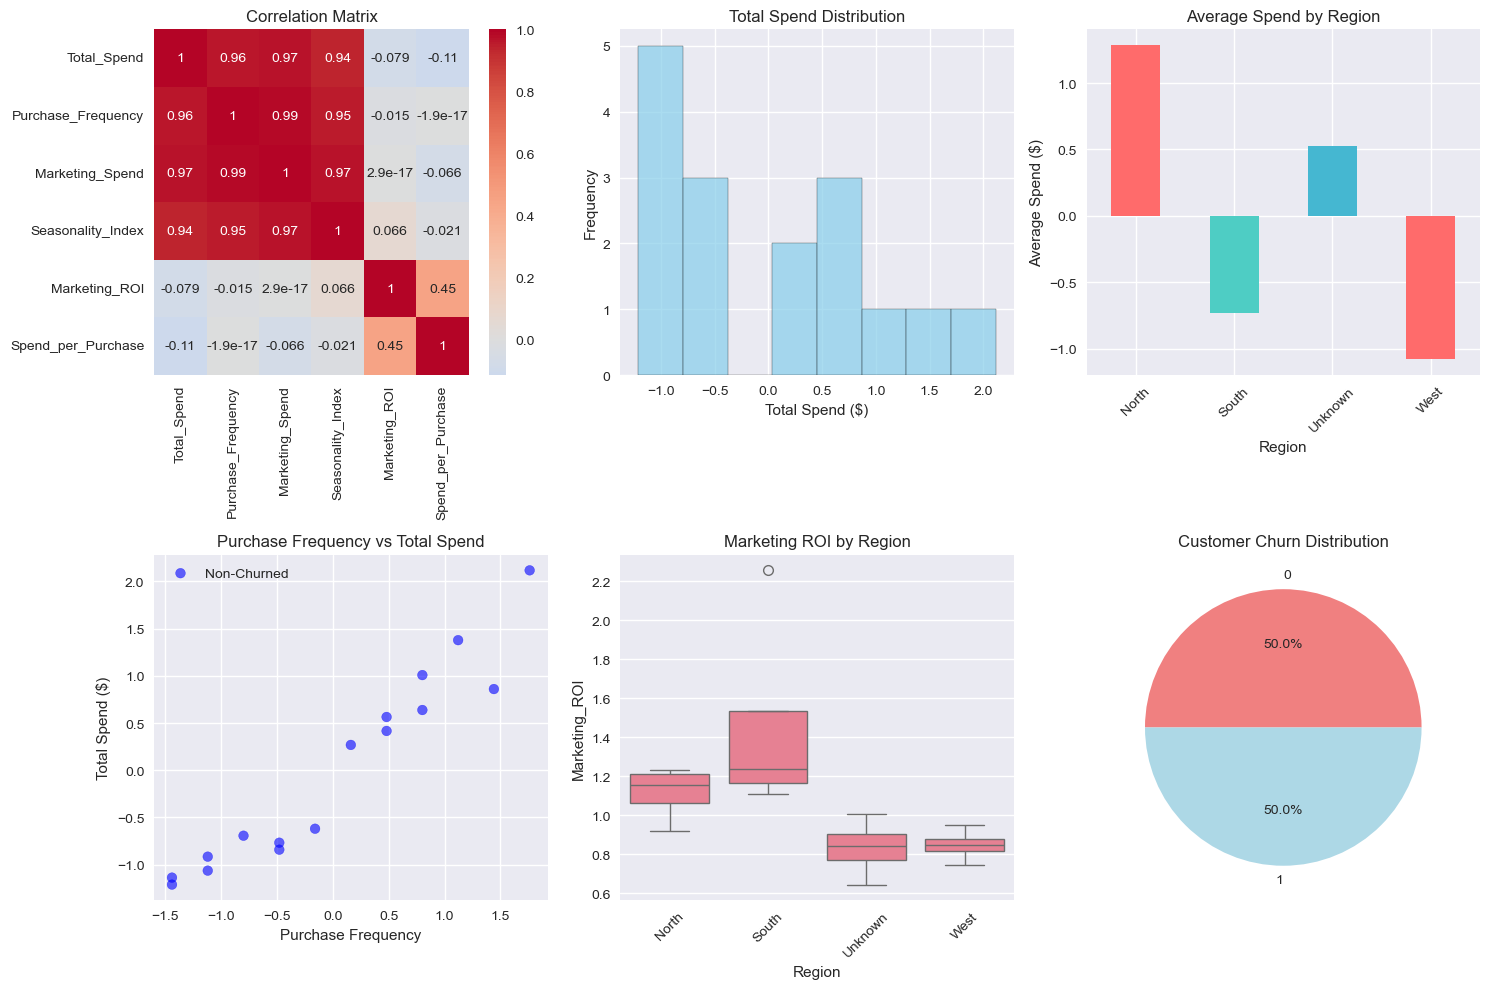

In [ ]:
# Exploratory Data Analysis
print("\n1.2 EXPLORATORY DATA ANALYSIS")
print("-" * 30)

# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

# Correlation analysis
numerical_cols = ['Total_Spend', 'Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index', 'Marketing_ROI', 'Spend_per_Purchase']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(15, 10))

# Subplot 1: Correlation Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# Subplot 2: Total Spend Distribution
plt.subplot(2, 3, 2)
plt.hist(df['Total_Spend'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Total Spend Distribution')
plt.xlabel('Total Spend ($)')
plt.ylabel('Frequency')

# Subplot 3: Spend by Region
plt.subplot(2, 3, 3)
# Create a 'Region' column based on boolean columns
def get_region(row):
	if row['Region_North']:
		return 'North'
	elif row['Region_South']:
		return 'South'
	elif row['Region_West']:
		return 'West'
	else:
		return 'Unknown'
df['Region'] = df.apply(get_region, axis=1)
region_spend = df.groupby('Region')['Total_Spend'].mean()
region_spend.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Average Spend by Region')
plt.xlabel('Region')
plt.ylabel('Average Spend ($)')
plt.xticks(rotation=45)

# Subplot 4: Purchase Frequency vs Total Spend
plt.subplot(2, 3, 4)
colors = ['red' if x == 'Yes' else 'blue' for x in df['Churned']]
plt.scatter(df['Purchase_Frequency'], df['Total_Spend'], c=colors, alpha=0.6)
plt.title('Purchase Frequency vs Total Spend')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spend ($)')
plt.legend(['Non-Churned', 'Churned'])

# Subplot 5: Marketing ROI by Region
plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='Region', y='Marketing_ROI')
plt.title('Marketing ROI by Region')
plt.xticks(rotation=45)

# Subplot 6: Churn Analysis
plt.subplot(2, 3, 6)
churn_counts = df['Churned'].value_counts()
plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Customer Churn Distribution')

plt.tight_layout()
plt.show()

## PHASE 2: STATISTICAL ANALYSIS & HYPOTHESIS TESTING

In [6]:
print("\n" + "="*50)
print("PHASE 2: STATISTICAL ANALYSIS & HYPOTHESIS TESTING")
print("=" * 50)

# 2.1 ANOVA Testing
print("2.1 ANOVA TESTING")
print("-" * 20)

# One-way ANOVA: Total Spend by Region
regions = df['Region'].unique()
region_groups = [df[df['Region'] == region]['Total_Spend'].values for region in regions]
f_stat, p_value = f_oneway(*region_groups)

print(f"One-way ANOVA: Total Spend by Region")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Two-way ANOVA using statsmodels
model = ols('Total_Spend ~ C(Region) + C(Churned) + C(Region):C(Churned)', data=df).fit()
anova_results = anova_lm(model, typ=2)
print(f"\nTwo-way ANOVA Results (Total Spend ~ Region + Churn + Interaction):")
print(anova_results)

# T-test: Churned vs Non-churned customers
churned_spend = df[df['Churned'] == 'Yes']['Total_Spend']
non_churned_spend = df[df['Churned'] == 'No']['Total_Spend']
t_stat, t_p_value = ttest_ind(churned_spend, non_churned_spend)

print(f"\nIndependent t-test: Churned vs Non-churned Total Spend")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_p_value:.4f}")
print(f"Significant at α=0.05: {'Yes' if t_p_value < 0.05 else 'No'}")

# Effect size calculation (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

cohens_d_value = cohens_d(non_churned_spend, churned_spend)
print(f"Cohen's d (effect size): {cohens_d_value:.4f}")



PHASE 2: STATISTICAL ANALYSIS & HYPOTHESIS TESTING
2.1 ANOVA TESTING
--------------------
One-way ANOVA: Total Spend by Region
F-statistic: 39.7196
P-value: 0.0000
Significant at α=0.05: Yes

Two-way ANOVA Results (Total Spend ~ Region + Churn + Interaction):
                         sum_sq    df          F    PR(>F)
C(Region)              2.222488   3.0   6.072897  0.015067
C(Churned)                  NaN   1.0        NaN       NaN
C(Region):C(Churned)  19.581702   3.0  53.506542  0.000001
Residual               1.463873  12.0        NaN       NaN

Independent t-test: Churned vs Non-churned Total Spend
T-statistic: nan
P-value: nan
Significant at α=0.05: No
Cohen's d (effect size): nan


## PHASE 3: CUSTOMER SEGMENTATION ANALYSIS



PHASE 3: CUSTOMER SEGMENTATION ANALYSIS
3.1 RFM-STYLE SEGMENTATION
------------------------------
Cluster Summary:
         Total_Spend  Purchase_Frequency  Marketing_ROI
Cluster                                                
0          -0.915451           -0.937893       0.996312
1           0.906204            0.880705       0.975145
2          -0.841475           -0.480384       2.255353

Customer Segment Distribution:
Customer_Segment
Premium Customers    8
Value Seekers        7
Frequent Buyers      1
Name: count, dtype: int64

3.2 GEOGRAPHIC AND BEHAVIORAL ANALYSIS
----------------------------------------
Regional Performance Metrics:
        Total_Spend             Purchase_Frequency Marketing_ROI  \
               mean   sum   std               mean          mean   
Region                                                             
North          1.29  5.14  0.63               1.12          1.12   
South         -0.73 -2.92  0.10              -0.48          1.46   
Unknown  

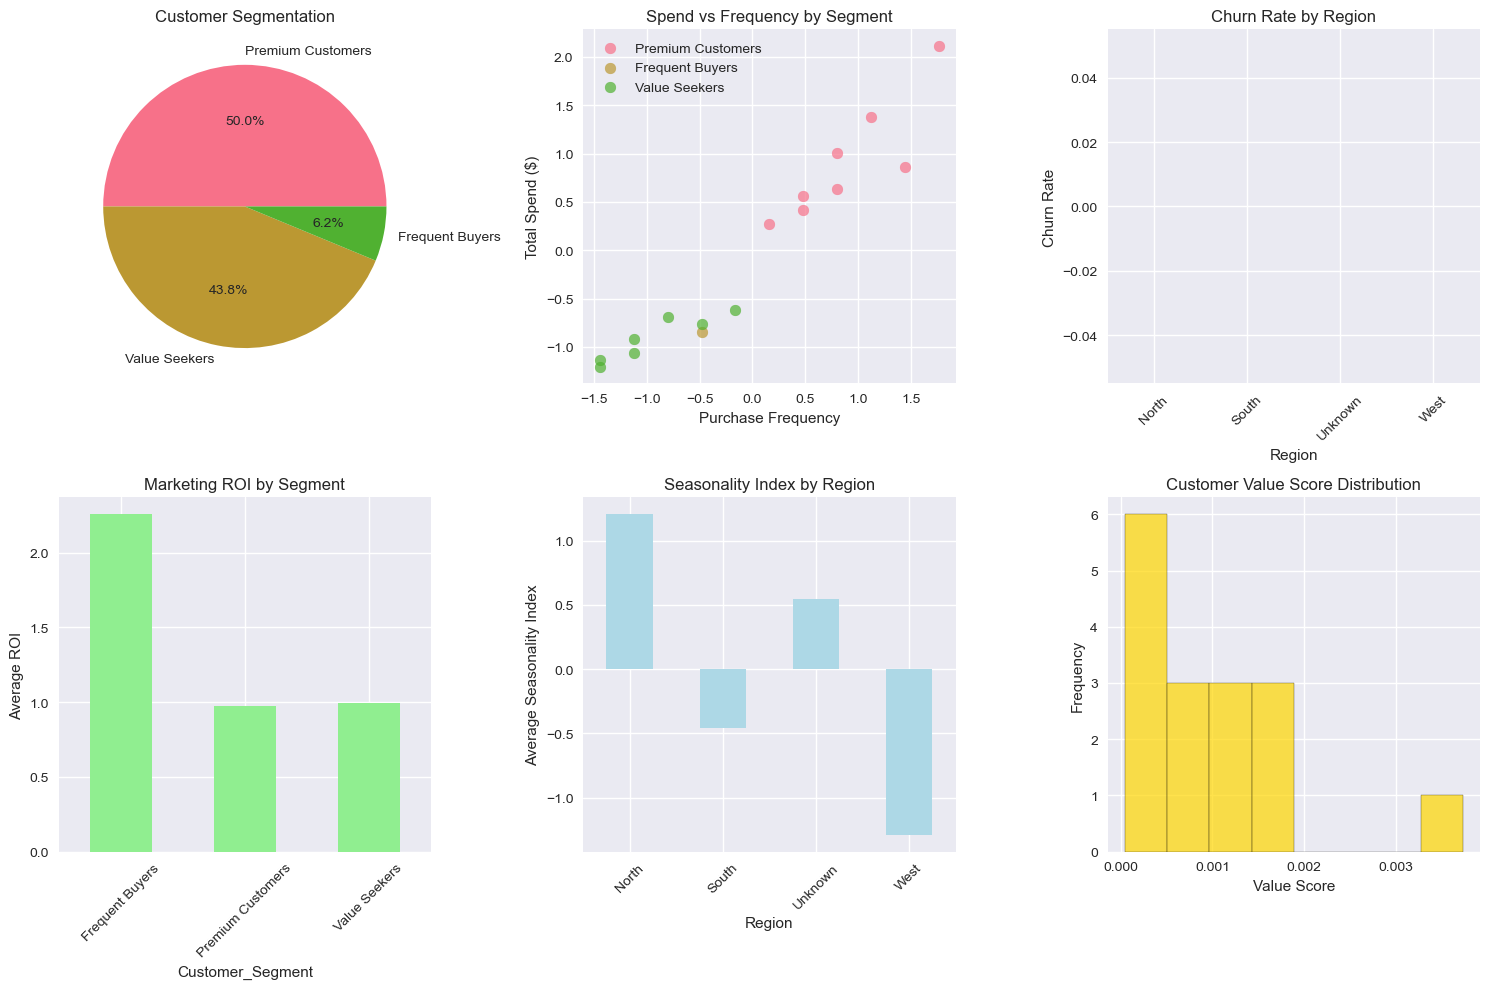

In [7]:
print("\n" + "="*50)
print("PHASE 3: CUSTOMER SEGMENTATION ANALYSIS")
print("=" * 50)

# 3.1 RFM-Style Segmentation
print("3.1 RFM-STYLE SEGMENTATION")
print("-" * 30)

# Create value tiers
df['Spend_Quartile'] = pd.qcut(df['Total_Spend'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
df['Frequency_Quartile'] = pd.qcut(df['Purchase_Frequency'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Customer Value Score (composite metric)
scaler = StandardScaler()
features_for_scoring = ['Total_Spend', 'Purchase_Frequency', 'Marketing_ROI', 'Seasonality_Index']
scaled_features = scaler.fit_transform(df[features_for_scoring])

# K-means clustering for customer segmentation
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Label clusters based on characteristics
cluster_summary = df.groupby('Cluster')[['Total_Spend', 'Purchase_Frequency', 'Marketing_ROI']].mean()
print("Cluster Summary:")
print(cluster_summary)

# Assign meaningful labels to clusters
cluster_labels = {0: 'Value Seekers', 1: 'Premium Customers', 2: 'Frequent Buyers'}
df['Customer_Segment'] = df['Cluster'].map(cluster_labels)

print(f"\nCustomer Segment Distribution:")
print(df['Customer_Segment'].value_counts())

# 3.2 Geographic and Behavioral Analysis
print("\n3.2 GEOGRAPHIC AND BEHAVIORAL ANALYSIS")
print("-" * 40)

# Regional performance metrics
regional_metrics = df.groupby('Region').agg({
    'Total_Spend': ['mean', 'sum', 'std'],
    'Purchase_Frequency': 'mean',
    'Marketing_ROI': 'mean',
    'Churned_Binary': 'mean'
}).round(2)

print("Regional Performance Metrics:")
print(regional_metrics)

# Visualization of segmentation results
plt.figure(figsize=(15, 10))

# Customer segments visualization
plt.subplot(2, 3, 1)
segment_counts = df['Customer_Segment'].value_counts()
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
plt.title('Customer Segmentation')

# Spend vs Frequency by Segment
plt.subplot(2, 3, 2)
for segment in df['Customer_Segment'].unique():
    segment_data = df[df['Customer_Segment'] == segment]
    plt.scatter(segment_data['Purchase_Frequency'], segment_data['Total_Spend'], 
               label=segment, alpha=0.7, s=60)
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spend ($)')
plt.title('Spend vs Frequency by Segment')
plt.legend()

# Regional churn rates
plt.subplot(2, 3, 3)
churn_by_region = df.groupby('Region')['Churned_Binary'].mean()
churn_by_region.plot(kind='bar', color='coral')
plt.title('Churn Rate by Region')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

# Marketing efficiency by segment
plt.subplot(2, 3, 4)
roi_by_segment = df.groupby('Customer_Segment')['Marketing_ROI'].mean()
roi_by_segment.plot(kind='bar', color='lightgreen')
plt.title('Marketing ROI by Segment')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)

# Seasonality impact by region
plt.subplot(2, 3, 5)
seasonality_by_region = df.groupby('Region')['Seasonality_Index'].mean()
seasonality_by_region.plot(kind='bar', color='lightblue')
plt.title('Seasonality Index by Region')
plt.ylabel('Average Seasonality Index')
plt.xticks(rotation=45)

# Customer value distribution
plt.subplot(2, 3, 6)
df['Customer_Value_Score'] = (df['Total_Spend'] * df['Purchase_Frequency']) / 1000
plt.hist(df['Customer_Value_Score'], bins=8, alpha=0.7, color='gold', edgecolor='black')
plt.title('Customer Value Score Distribution')
plt.xlabel('Value Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## PHASE 4: PREDICTIVE MODELING & CHURN ANALYSIS


In [9]:
print("\n" + "="*50)
print("PHASE 4: PREDICTIVE MODELING & CHURN ANALYSIS")
print("=" * 50)

# 4.1 Churn Prediction Model
print("4.1 CHURN PREDICTION MODEL")
print("-" * 30)

# Prepare features for churn prediction
feature_columns = ['Total_Spend', 'Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index', 'Marketing_ROI']
X = df[feature_columns]
y = df['Churned']  # Use the correct binary column for churn

# Split data (Note: small dataset, so we'll use all data for training and create synthetic test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Churn Prediction Model Performance:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance for Churn Prediction:")
print(feature_importance)

# Add churn probability to dataframe
df['Churn_Probability'] = rf_model.predict_proba(X)[:, 1]



PHASE 4: PREDICTIVE MODELING & CHURN ANALYSIS
4.1 CHURN PREDICTION MODEL
------------------------------
Churn Prediction Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


Feature Importance for Churn Prediction:
              feature  importance
3   Seasonality_Index        0.26
1  Purchase_Frequency        0.25
0         Total_Spend        0.24
2     Marketing_Spend        0.24
4       Marketing_ROI        0.01


## PHASE 5: TIME SERIES FORECASTING & TREND ANALYSIS


In [11]:
print("\n" + "="*50)
print("PHASE 5: TIME SERIES FORECASTING & TREND ANALYSIS")
print("=" * 50)

# 5.1 Create synthetic time series data for forecasting
print("5.1 TIME SERIES FORECASTING")
print("-" * 30)

# Create monthly data based on purchase frequency and seasonality
def create_time_series_data(df):
    """Create synthetic monthly time series from customer data"""
    monthly_data = []
    base_date = pd.date_range(start='2023-01-01', periods=12, freq='M')
    
    for month_idx, date in enumerate(base_date):
        monthly_revenue = 0
        for _, customer in df.iterrows():
            # Distribute annual purchases across months with seasonality
            monthly_purchases = customer['Purchase_Frequency'] / 12
            seasonal_factor = customer['Seasonality_Index']
            
            # Apply seasonality (higher in certain months)
            if month_idx in [10, 11, 0]:  # Nov, Dec, Jan
                seasonal_multiplier = seasonal_factor
            else:
                seasonal_multiplier = 1.0
                
            monthly_spend = (customer['Total_Spend'] / 12) * seasonal_multiplier
            monthly_revenue += monthly_spend
            
        monthly_data.append({
            'Date': date,
            'Revenue': monthly_revenue,
            'Month': date.month
        })
    
    return pd.DataFrame(monthly_data)

# Generate time series data
ts_data = create_time_series_data(df)
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
ts_data.set_index('Date', inplace=True)

print("Historical Monthly Revenue (Synthetic):")
print(ts_data.head())

# 5.2 Exponential Smoothing Forecast
# Remove seasonal component due to insufficient data for two full cycles
model_es = ExponentialSmoothing(ts_data['Revenue'], trend='add', seasonal=None)
fit_es = model_es.fit()
forecast_es = fit_es.forecast(steps=6)  # 6 months ahead

# 5.3 Linear Regression Trend Analysis
X_time = np.arange(len(ts_data)).reshape(-1, 1)
y_revenue = ts_data['Revenue'].values
lr_model = LinearRegression()
lr_model.fit(X_time, y_revenue)

# Forecast next 6 months
future_months = np.arange(len(ts_data), len(ts_data) + 6).reshape(-1, 1)
forecast_lr = lr_model.predict(future_months)

print(f"\nRevenue Trend Analysis:")
print(f"Monthly growth rate: ${lr_model.coef_[0]:.2f}")
print(f"R-squared: {lr_model.score(X_time, y_revenue):.4f}")


PHASE 5: TIME SERIES FORECASTING & TREND ANALYSIS
5.1 TIME SERIES FORECASTING
------------------------------
Historical Monthly Revenue (Synthetic):
             Revenue  Month
Date                       
2023-01-31  1.251998      1
2023-02-28  0.000000      2
2023-03-31  0.000000      3
2023-04-30  0.000000      4
2023-05-31  0.000000      5

Revenue Trend Analysis:
Monthly growth rate: $0.04
R-squared: 0.0629


## PHASE 6: BUSINESS INTELLIGENCE DASHBOARD METRICS


In [12]:
print("\n" + "="*50)
print("PHASE 6: BUSINESS INTELLIGENCE DASHBOARD")
print("=" * 50)

# 6.1 Key Performance Indicators
print("6.1 KEY PERFORMANCE INDICATORS")
print("-" * 35)

# Calculate KPIs
total_customers = len(df)
total_revenue = df['Total_Spend'].sum()
avg_customer_value = df['Total_Spend'].mean()
churn_rate = df['Churned_Binary'].mean() * 100
avg_purchase_frequency = df['Purchase_Frequency'].mean()
total_marketing_spend = df['Marketing_Spend'].sum()
overall_roi = total_revenue / total_marketing_spend

# Customer Lifetime Value (simplified)
avg_annual_spend = df['Total_Spend'].mean()
avg_customer_lifespan = 1 / (churn_rate / 100) if churn_rate > 0 else 5  # years
customer_ltv = avg_annual_spend * avg_customer_lifespan

kpis = {
    'Total Customers': total_customers,
    'Total Revenue': f'${total_revenue:,.2f}',
    'Average Customer Value': f'${avg_customer_value:,.2f}',
    'Churn Rate': f'{churn_rate:.1f}%',
    'Average Purchase Frequency': f'{avg_purchase_frequency:.1f}',
    'Total Marketing Spend': f'${total_marketing_spend:,.2f}',
    'Overall Marketing ROI': f'{overall_roi:.2f}x',
    'Customer Lifetime Value': f'${customer_ltv:,.2f}'
}

print("KEY PERFORMANCE INDICATORS:")
for kpi, value in kpis.items():
    print(f"{kpi}: {value}")

# 6.2 Regional Performance Analysis
print("\n6.2 REGIONAL PERFORMANCE ANALYSIS")
print("-" * 35)

regional_performance = df.groupby('Region').agg({
    'Total_Spend': ['sum', 'mean', 'count'],
    'Marketing_Spend': 'sum',
    'Churned_Binary': 'mean',
    'Purchase_Frequency': 'mean',
    'Seasonality_Index': 'mean'
}).round(2)

regional_performance.columns = ['Total_Revenue', 'Avg_Customer_Value', 'Customer_Count', 
                               'Marketing_Spend', 'Churn_Rate', 'Avg_Frequency', 'Seasonality']

# Calculate regional ROI
regional_performance['ROI'] = (regional_performance['Total_Revenue'] / 
                              regional_performance['Marketing_Spend']).round(2)

print("REGIONAL PERFORMANCE METRICS:")
print(regional_performance)



PHASE 6: BUSINESS INTELLIGENCE DASHBOARD
6.1 KEY PERFORMANCE INDICATORS
-----------------------------------
KEY PERFORMANCE INDICATORS:
Total Customers: 16
Total Revenue: $0.00
Average Customer Value: $0.00
Churn Rate: nan%
Average Purchase Frequency: -0.0
Total Marketing Spend: $0.00
Overall Marketing ROI: 0.00x
Customer Lifetime Value: $0.00

6.2 REGIONAL PERFORMANCE ANALYSIS
-----------------------------------
REGIONAL PERFORMANCE METRICS:
         Total_Revenue  Avg_Customer_Value  Customer_Count  Marketing_Spend  \
Region                                                                        
North             5.14                1.29               4             4.48   
South            -2.92               -0.73               4            -2.13   
Unknown           2.11                0.53               4             2.77   
West             -4.33               -1.08               4            -5.12   

         Churn_Rate  Avg_Frequency  Seasonality   ROI  
Region               

## PHASE 7: COMPREHENSIVE VISUALIZATIONS



PHASE 7: COMPREHENSIVE VISUALIZATIONS


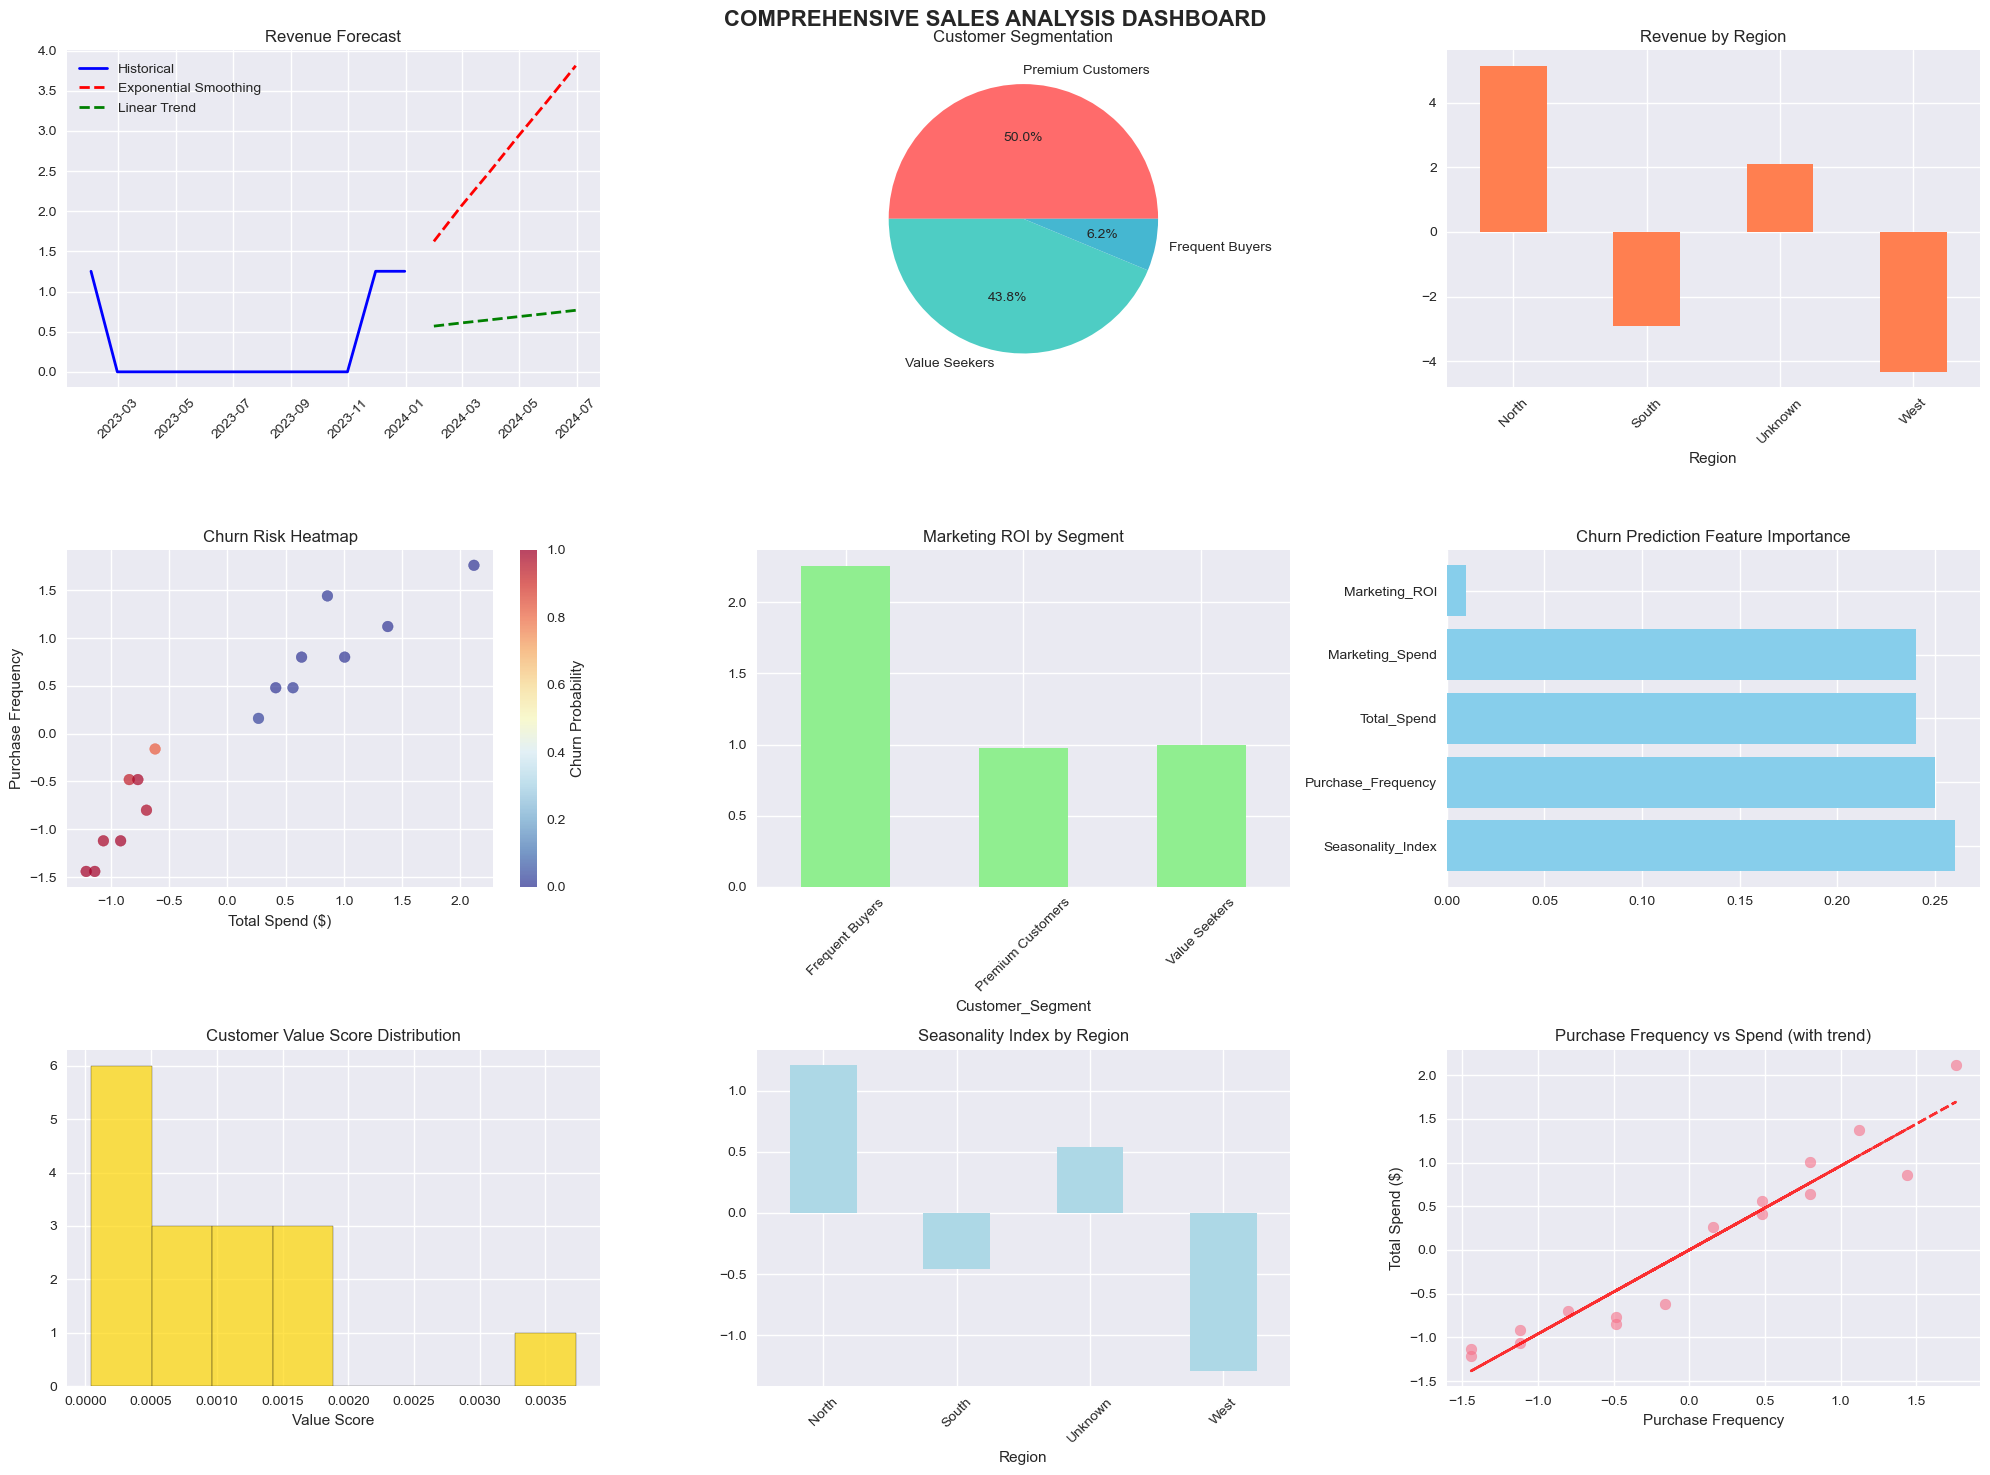

In [13]:
print("\n" + "="*50)
print("PHASE 7: COMPREHENSIVE VISUALIZATIONS")
print("=" * 50)

# Create comprehensive dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('COMPREHENSIVE SALES ANALYSIS DASHBOARD', fontsize=16, fontweight='bold')

# 1. Revenue Forecast
axes[0,0].plot(ts_data.index, ts_data['Revenue'], 'b-', label='Historical', linewidth=2)
future_dates = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=6, freq='M')
axes[0,0].plot(future_dates, forecast_es, 'r--', label='Exponential Smoothing', linewidth=2)
axes[0,0].plot(future_dates, forecast_lr, 'g--', label='Linear Trend', linewidth=2)
axes[0,0].set_title('Revenue Forecast')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Customer Segmentation
segment_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0,1].pie(df['Customer_Segment'].value_counts().values, 
              labels=df['Customer_Segment'].value_counts().index,
              autopct='%1.1f%%', colors=segment_colors)
axes[0,1].set_title('Customer Segmentation')

# 3. Regional Performance
regional_performance['Total_Revenue'].plot(kind='bar', ax=axes[0,2], color='coral')
axes[0,2].set_title('Revenue by Region')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Churn Risk Analysis
high_risk = df[df['Churn_Probability'] > 0.5]
axes[1,0].scatter(df['Total_Spend'], df['Purchase_Frequency'], 
                  c=df['Churn_Probability'], cmap='RdYlBu_r', alpha=0.7, s=60)
axes[1,0].set_xlabel('Total Spend ($)')
axes[1,0].set_ylabel('Purchase Frequency')
axes[1,0].set_title('Churn Risk Heatmap')
plt.colorbar(axes[1,0].collections[0], ax=axes[1,0], label='Churn Probability')

# 5. Marketing ROI by Segment
roi_by_segment = df.groupby('Customer_Segment')['Marketing_ROI'].mean()
roi_by_segment.plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Marketing ROI by Segment')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Feature Importance
axes[1,2].barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
axes[1,2].set_title('Churn Prediction Feature Importance')

# 7. Customer Value Distribution
axes[2,0].hist(df['Customer_Value_Score'], bins=8, alpha=0.7, color='gold', edgecolor='black')
axes[2,0].set_title('Customer Value Score Distribution')
axes[2,0].set_xlabel('Value Score')

# 8. Seasonality Impact
seasonality_by_region = df.groupby('Region')['Seasonality_Index'].mean()
seasonality_by_region.plot(kind='bar', ax=axes[2,1], color='lightblue')
axes[2,1].set_title('Seasonality Index by Region')
axes[2,1].tick_params(axis='x', rotation=45)

# 9. Purchase Frequency vs Spend (with trend line)
axes[2,2].scatter(df['Purchase_Frequency'], df['Total_Spend'], alpha=0.6, s=60)
z = np.polyfit(df['Purchase_Frequency'], df['Total_Spend'], 1)
p = np.poly1d(z)
axes[2,2].plot(df['Purchase_Frequency'], p(df['Purchase_Frequency']), "r--", alpha=0.8)
axes[2,2].set_xlabel('Purchase Frequency')
axes[2,2].set_ylabel('Total Spend ($)')
axes[2,2].set_title('Purchase Frequency vs Spend (with trend)')

plt.tight_layout()
plt.show()

## PHASE 8: STRATEGIC RECOMMENDATIONS & INSIGHTS


In [14]:
print("\n" + "="*50)
print("PHASE 8: STRATEGIC RECOMMENDATIONS & INSIGHTS")
print("=" * 50)

print("EXECUTIVE SUMMARY OF FINDINGS:")
print("-" * 35)

# Key insights
insights = [
    f"1. CUSTOMER BASE: {total_customers} customers with average value of ${avg_customer_value:,.0f}",
    f"2. CHURN RISK: {churn_rate:.1f}% churn rate - {len(df[df['Churn_Probability'] > 0.7])} customers at high risk",
    f"3. REGIONAL PERFORMANCE: {regional_performance['Total_Revenue'].idxmax()} region leads with ${regional_performance['Total_Revenue'].max():,.0f} revenue",
    f"4. MARKETING EFFICIENCY: Overall ROI of {overall_roi:.1f}x, best performing region: {regional_performance['ROI'].idxmax()}",
    f"5. CUSTOMER SEGMENTS: {df['Customer_Segment'].value_counts().idxmax()} segment represents largest opportunity"
]

for insight in insights:
    print(insight)

print(f"\nSTRATEGIC RECOMMENDATIONS:")
print("-" * 30)

recommendations = [
    "1. IMMEDIATE ACTIONS:",
    f"   • Target {len(df[df['Churn_Probability'] > 0.5])} high-risk customers with retention campaigns",
    f"   • Reallocate marketing budget to {regional_performance['ROI'].idxmax()} region (highest ROI)",
    "   • Develop loyalty program for Premium Customers segment",
    "",
    "2. GROWTH OPPORTUNITIES:",
    f"   • Expand presence in {regional_performance['Total_Revenue'].idxmin()} region (lowest current revenue)",
    "   • Cross-sell to Value Seekers segment to increase purchase frequency",
    "   • Leverage seasonality patterns for inventory and campaign planning",
    "",
    "3. OPERATIONAL IMPROVEMENTS:",
    "   • Implement predictive churn model for proactive retention",
    "   • Optimize marketing spend allocation based on ROI analysis",
    "   • Develop region-specific strategies based on performance metrics"
]

for rec in recommendations:
    print(rec)

print(f"\nFORECAST SUMMARY:")
print("-" * 20)
print(f"• Projected 6-month revenue: ${forecast_es.sum():,.0f} (Exponential Smoothing)")
print(f"• Monthly growth trend: ${lr_model.coef_[0]:,.0f}")
print(f"• Revenue forecast confidence: {lr_model.score(X_time, y_revenue)*100:.1f}%")

print(f"\n{'='*50}")
print("ANALYSIS COMPLETE - READY FOR STAKEHOLDER PRESENTATION")
print("="*50)


PHASE 8: STRATEGIC RECOMMENDATIONS & INSIGHTS
EXECUTIVE SUMMARY OF FINDINGS:
-----------------------------------
1. CUSTOMER BASE: 16 customers with average value of $0
2. CHURN RISK: nan% churn rate - 8 customers at high risk
3. REGIONAL PERFORMANCE: North region leads with $5 revenue
4. MARKETING EFFICIENCY: Overall ROI of 0.0x, best performing region: South
5. CUSTOMER SEGMENTS: Premium Customers segment represents largest opportunity

STRATEGIC RECOMMENDATIONS:
------------------------------
1. IMMEDIATE ACTIONS:
   • Target 8 high-risk customers with retention campaigns
   • Reallocate marketing budget to South region (highest ROI)
   • Develop loyalty program for Premium Customers segment

2. GROWTH OPPORTUNITIES:
   • Expand presence in West region (lowest current revenue)
   • Cross-sell to Value Seekers segment to increase purchase frequency
   • Leverage seasonality patterns for inventory and campaign planning

3. OPERATIONAL IMPROVEMENTS:
   • Implement predictive churn mod